In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

import thesis
chapter = 'theory'
save = False

In [2]:
from kid_readout.measurement.io import npy
from kid_readout.analysis.resonator import lmfit_resonator

In [3]:
npd = npy.NumpyDirectory('/data/detectors/2016-10-18_124841_sweep_stream_on_off/')

In [4]:
lo_index = 5
attenuation_index = 2

measurements_per_sss = 4 # SingleSweepStream, SingleSweep, SingleStream, ADCSnap
num_attenuations = 4
index = measurements_per_sss * (lo_index * num_attenuations + attenuation_index) 
sss = npd.read('SingleSweepStream{}'.format(index))

In [5]:
sss.state.lo_index == lo_index

True

In [6]:
sss.stream.roach_state.dac_attenuation

40.0

In [7]:
# Re-fit the resonator
sss.sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)

In [8]:
xlabel_a = '$\\mathrm{{Re}} \\, R_{{21}}$' + '\n' + '${{\\bf (a)}}$'
xlabel_b = '$\\mathrm{{Re}} \\, S_{{21}}$' + '\n' + '${{\\bf (b)}}$'
ylabel_a = '$\\mathrm{{Im}} \\, R_{{21}}$'
ylabel_b = '$\\mathrm{{Im}} \\, S_{{21}}$'

In [9]:
sss.resonator.asymmetry

0.29488660232266639

In [10]:
print("f_r = {:.1f} GHz".format(1e-9 * sss.resonator.f_0))

f_r = 3.5 GHz


In [11]:
print("The sweep spans {:.1f} MHz".format(1e-6 * sss.resonator.frequency.ptp()))

The sweep spans 2.0 MHz


In [12]:
print("loss_i = {:.2g} = 1 / {:.0f}".format(sss.resonator.loss_i, 1 / sss.resonator.loss_i))

loss_i = 8.9e-06 = 1 / 112375


In [13]:
print("loss_c = {:.2g} = 1 / {:.0f}".format(sss.resonator.loss_c, 1 / sss.resonator.loss_c))

loss_c = 3.2e-05 = 1 / 30853


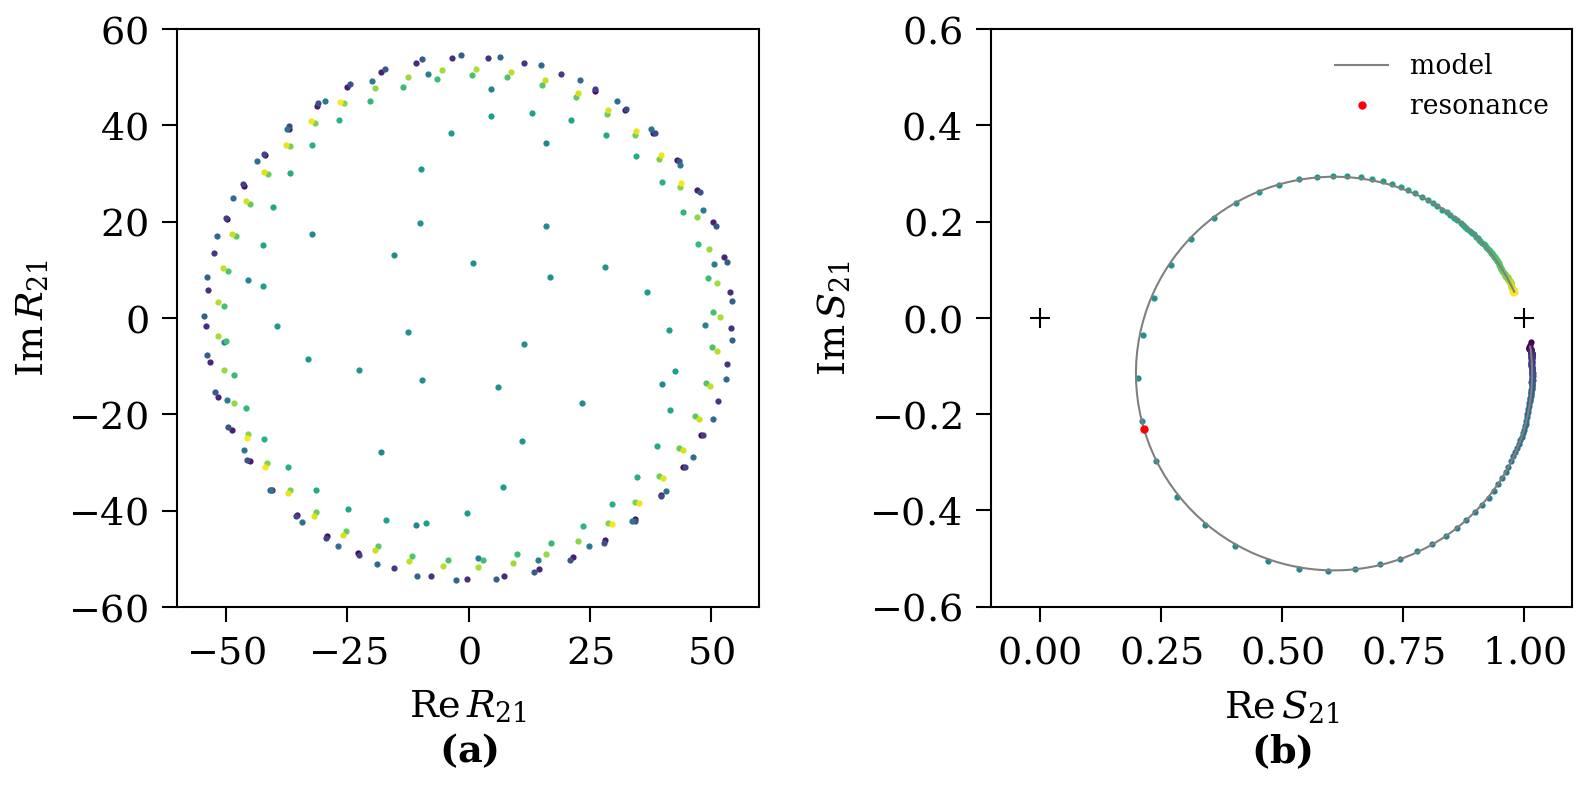

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'wspace': 0.4})
axes[0].set_xlabel(xlabel_a)
axes[0].set_ylabel(ylabel_a)
axes[1].set_xlabel(xlabel_b)
axes[1].set_ylabel(ylabel_b)
model_color = 'gray'
resonance_color = 'red'

raw = sss.resonator.extract(normalize=False)
tone_bins = np.array([stream.tone_bin[stream.tone_index] for stream in sss.sweep.streams])
# Reverse the phase unwrapping done by Demodulator
wrapped = raw.s21_data / np.exp(2j * np.pi * sss.stream.roach_state.hardware_delay_samples * 
                                tone_bins / sss.stream.roach_state.num_tone_samples)

normalized = sss.resonator.extract(normalize=True)
mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=raw.f_data.min(),
                                                           vmax=raw.f_data.max()),
                                 cmap=plt.cm.viridis)

for f, s21 in zip(raw.f_data, wrapped):
    axes[0].plot(s21.real, s21.imag, '.', color=mappable.to_rgba(f))

for f, s21 in zip(normalized.f_data, normalized.s21_data):
    axes[1].plot(s21.real, s21.imag, '.', color=mappable.to_rgba(f))
axes[1].plot(normalized.s21_model.real, normalized.s21_model.imag, color=model_color, label='model')
axes[1].plot(normalized.s21_0.real, normalized.s21_0.imag,
             '.', markersize=4, color=resonance_color, label='resonance');
axes[1].plot(0, 0, '+', markersize=5, markeredgewidth=0.5, color='black')
axes[1].plot(1, 0, '+', markersize=5, markeredgewidth=0.5, color='black')
axes[1].set_xlim(-0.1, 1.1)
axes[1].set_ylim(-0.6, 0.6)
axes[1].legend(fontsize='xx-small')

if save:
    fig.savefig(save_directory + 'example_resonator_fit.pdf')